# Quantum Kernel Training for Machine Learning Applications

In this tutorial, we will train a quantum kernel on a labeled dataset for a machine learning application. To illustrate the basic steps, we will use Quantum Kernel Alignment (QKA) for a binary classification task. QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the [background material](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/svm_weighted_kernel_alignment.ipynb) and in the preprint ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)

The QKT Tookit enables kernel training for loss functions and learning problems beyond QKA. Check out the [how-to guides](https://github.com/qiskit-community/prototype-quantum-kernel-training/tree/main/docs/how_tos) for information on building custom kernel training algorithms within this framework.  

The entry point to training a quantum kernel is the `QuantumKernelTrainer`. The basic steps are:

1. Prepare the dataset
2. Define the quantum feature map
3. Set up the `QuantumKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit_kernel` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

### Import Local, External, and Qiskit Packages

In [11]:
# pylint: disable=import-error, wrong-import-position

# Python imports
import os
import sys
import io
import time

# External imports
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib as matl
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from IPython.display import display

import pandas as pd
import sklearn.preprocessing as skpp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import cluster, datasets, mixture



np.random.seed(19)

%matplotlib inline

# Qiskit imports
from qiskit import BasicAer
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

# Put this repository on the Python path and import qkt pkgs
path = 'prototype-quantum-kernel-training'
  # Check whether the specified
# path exists or not
Exist = os.path.exists(path)

#Si no existe el path clonaremos el repositorio en ese path, si ya existe no haremos nada.
if Exist == False: 
    print('Clonando Repositorio...')
    !git clone https://github.com/qiskit-community/prototype-quantum-kernel-training.git
    
else: 
    print('No se clonará el repositorio debido a que ya existe en el sistema')
    
module_path = os.path.abspath(os.path.join(path))
sys.path.append(module_path)
from qkt.feature_maps import CovariantFeatureMap
from qkt.utils import train_test_split, QKTCallback

No se clonará el repositorio debido a que ya existe en el sistema


### Prepare the Dataset

We start by preparing the dataset. In this example, we load the file `Data_16qubit_noisy.csv` from the QKT Toolkit located [here](https://github.com/qiskit-community/prototype-quantum-kernel-training/tree/main/data). More information about the structure of this particular dataset is in the [background material](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). If we inspect the dataset, we see that each sample has $16\times2=32$ features and the labels are binary $\pm1$.

In [12]:
# Load the dataset and split into train and test sets
DATA_FILEPATH = "Data_10qubit.csv"

num_train = 25
num_test = 15
#Train test split
df = pd.read_csv(DATA_FILEPATH,header = None)

df.loc[df[20] == 2, 20] = -1
df = df.sample(frac=1).reset_index(drop=True)

data = df.values


train = data[:2*num_train, :]
test = data[2*num_train:2*(num_train+num_test), :]

ind = np.argsort(train[:,-1])
X_train = train[ind][:,:-1]
y_train = train[ind][:,-1]

ind = np.argsort(test[:,-1])
X_test = test[ind][:,:-1]
y_test = test[ind][:,-1]

### Define the Quantum Feature Map

Next, we set up the quantum feature map, which encodes classical data into the quantum state space. Here, we import the `CovariantFeatureMap` map from the QKT Toolkit. This feature map is tailored to the group structure of this particular dataset. For a deeper look into covariant quantum kernels for data with group structure check out the [background material](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). For more information on defining quantum feature maps in Qiskit, check out our guides on [creating custom feature maps](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/create_custom_quantum_feature_map.ipynb) and [building trainable feature maps from existing circuits in Qiskit's circuit library](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/train_kernels_using_qiskit_feature_maps.ipynb). 

To instantiate the `CovariantFeatureMap`, we specify:
- Feature dimension
- Entanglement structure of the quantum circuit
- Type of parametrization for the trainable parameters

In this example, we set the `feature_dimension` to that of the dataset. In addition, the `entanglement` parameter controls the structure of the [fiducial state of the covariant quantum feature map](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). We choose `entanglement` to match the graph used to generate the dataset (a subgraph of the [heavy-hexagon lattice](https://www.ibm.com/blogs/research/2020/09/hardware-aware-quantum/)). With this selection, we expect our model to perform well on this dataset. However, other entanglement structures can be used if one does not have prior knowledge of what might constitute a good choice.

We parametrize our quantum feature map with a single parameter (a rotation angle) applied to all qubits. Alternatively, we could apply a unique, independent parameter to each qubit by setting the `single_training_parameter` flag to `False` in `CovariantFeatureMap`.

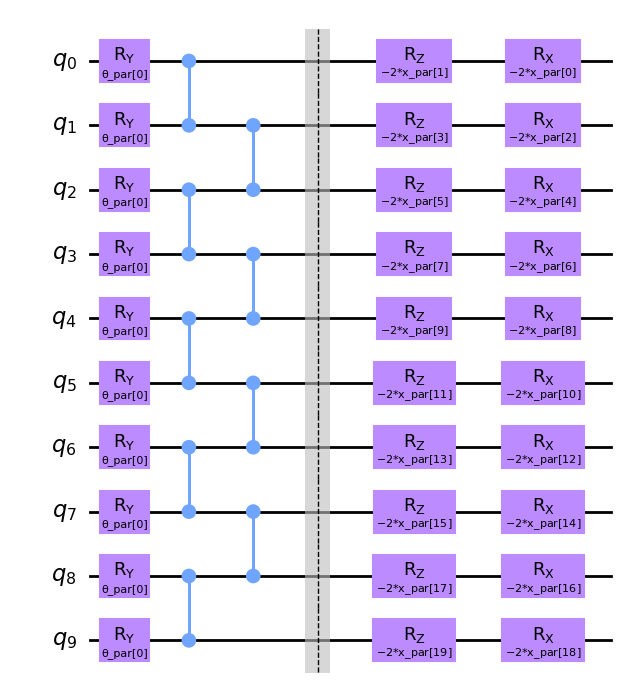

In [13]:
num_features = np.shape(X_train)[1]
entangler_map = [[0,1],[2,3],[4,5],[6,7],[8,9],[1,2],[3,4],[5,6],[7,8]] # is a suitable input for the 10-qubit dataset

fm = CovariantFeatureMap(
    feature_dimension=num_features,
    entanglement=entangler_map,
    single_training_parameter=True,
)
circuit_drawer(fm)

The trainable parameters can be extracted from the CovariantFeatureMap class (in this case, a single parameter for all qubits):

In [14]:
print(fm.user_parameters)

θ_par, ['θ_par[0]']


### Set Up the Quantum Kernel and Quantum Kernel Trainer

To train the quantum kernel, we need a `QuantumKernel` (holds the feature map and its parameters as well as a backend) and `QuantumKernelTrainer` (manages the training process).

Since we will train with a Qiskit-supported loss function, `SVCLoss`, we specify the corresponding loss function of the `QuantumKernelTrainer` with the string `"svc_loss"`. Note that default settings of the loss function are used when passing it as a string. For custom settings, instantiate the loss explicitly with the desired values. Check out [this guide](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/create_custom_kernel_loss_function.ipynb) on how to define and use custom kernel loss functions. 

Additionally, we select SPSA as the optimizer and initialize the trainable parameter to 0.1 with `initial_point`.

*Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.*

In [15]:
# Use the qasm simulator backend
backend = BasicAer.get_backend("statevector_simulator")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(
    fm, training_parameters=fm.user_parameters, quantum_instance=backend
)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(
    maxiter=10, callback=cb_qkt.callback, learning_rate=0.1, perturbation=0.1
)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,
    loss="svc_loss",
    optimizer=spsa_opt,
    initial_point=[0.1] * len(fm.user_parameters),
)

### Train the Quantum Kernel

To train the quantum kernel on the dataset (samples and labels), we call the `fit_kernel` method of `QuantumKernelTrainer`.

In [16]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel

### Fit and Test the Model

We can pass the trained quantum kernel to a machine learning model, then fit the model and test on new data. Here, we will use Qiskit's `QSVC` for classification.

In [17]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel,C = 1)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)
labels_train = qsvc.predict(X_train)

# Evaluate the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

# Evaluate the train accuracy
accuracy_train = metrics.balanced_accuracy_score(y_true=y_train, y_pred=labels_train)
print(f"accuracy train: {accuracy_train}")

accuracy test: 1.0
accuracy train: 1.0


### Visualize the Kernel Training Process

From the callback data, we can plot how the loss evolves during the training process. We see it converges rapidly and reaches 100% test accuracy on this dataset with our choice of inputs.

We can also display the final kernel matrix evaluated on the training data. As expected for this dataset, the matrix has a block-diagonal structure. This reflects the fact that this covariant quantum kernel maps the input data of this learning problem to [approximately two quantum feature states](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). The small noise that was added to the data, along with the noise when evaluating on a real quantum device, perturbs these two feature states into two small clusters of feature states that should remain easily separable by the machine learning model when the noise is sufficiently small.

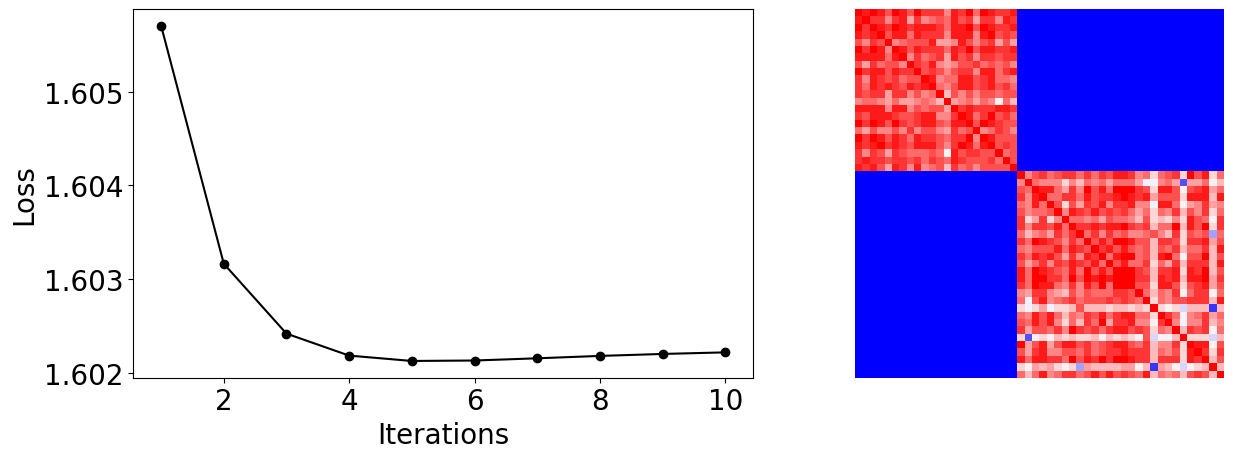

In [18]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(
    X_train
)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(
    [i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o"
)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
ax[1].axis("off")
fig.tight_layout()
plt.show()

In [19]:
grid = [{'C': [0.1,1,10,150],
         'gamma': ['auto','scale',1.0,0.1], 
         'kernel': ['rbf','poly'],
         'degree': [1,2,3,4,5],
         'coef0':[1.0]}]

clf_gridsearch = GridSearchCV(estimator=SVC(probability=True), param_grid=grid, cv=5)
start = time.time()
clf_gridsearch.fit(X_train, y_train) 
stop = time.time()
print(f"Training time: {stop - start}s") 

# Imprimimos los resultados para el mejor clasificador:
clf = clf_gridsearch.best_estimator_
print("Best model:")
print(clf.get_params())

# Calculamos el acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(X_train, y_train)
print("Score in training set = %f" % (score_train))

score_test = clf.score(X_test, y_test)
print("Score in test set = %f" % (score_test))

Training time: 1.3579678535461426s
Best model:
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Score in training set = 1.000000
Score in test set = 0.933333


In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright